In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle
from specutils.utils.wcs_utils import vac_to_air, air_to_vac

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_1s_proto.h5", 'r') as hf:
    bias_dc_green_1s = hf['image'][:]


In [3]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"
helium_im_collection = ImageFileCollection(green_path,
                            filenames=["HeliumGreenpoint1s_24605.fit","HeliumGreenpoint1s_24606.fit","HeliumGreenpoint1s_24607.fit",
                            "HeliumGreenpoint1s_24608.fit","HeliumGreenpoint1s_24609.fit","HeliumGreenpoint1s_24610.fit",
                            "HeliumGreenpoint1s_24611.fit","HeliumGreenpoint1s_24612.fit","HeliumGreenpoint1s_24613.fit",
                            "HeliumGreenpoint1s_24614.fit"])
helium_im_df = helium_im_collection.summary.to_pandas()

In [4]:
helium_im_df

,file,simple,bitpix,naxis,naxis1,naxis2,bzero,bscale,datamin,datamax,...,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,xpossubf,ypossubf,cblack,cwhite,swcreate
0,HeliumGreenpoint1s_24605.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,759,30061,Artemis Capture
1,HeliumGreenpoint1s_24606.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,749,28995,Artemis Capture
2,HeliumGreenpoint1s_24607.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,764,28047,Artemis Capture
3,HeliumGreenpoint1s_24608.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,757,24980,Artemis Capture
4,HeliumGreenpoint1s_24609.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,754,26159,Artemis Capture
5,HeliumGreenpoint1s_24610.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,760,26649,Artemis Capture
6,HeliumGreenpoint1s_24611.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,760,26773,Artemis Capture
7,HeliumGreenpoint1s_24612.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,759,26534,Artemis Capture
8,HeliumGreenpoint1s_24613.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,757,25424,Artemis Capture
9,HeliumGreenpoint1s_24614.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,761,25406,Artemis Capture


In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

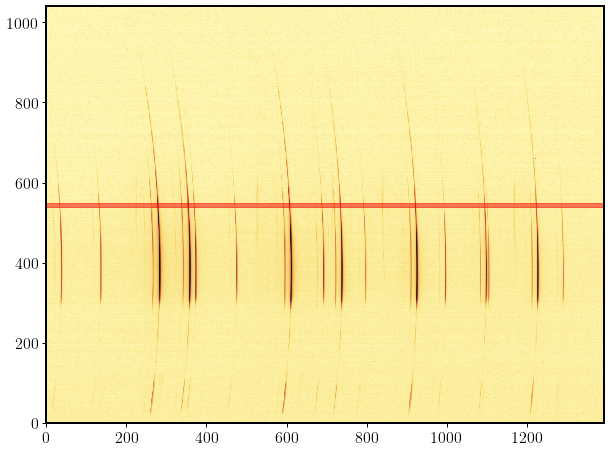

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
im = ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
#plt.colorbar(im)
ax.axis("scaled")
bottom_pixel = 540
top_pixel = 550
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

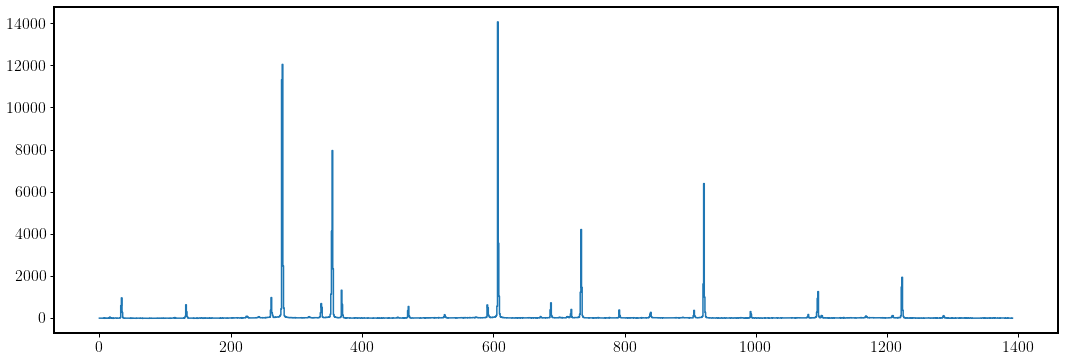

In [7]:
helium_spectrum_example = np.mean(helium_im_aver[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, helium_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

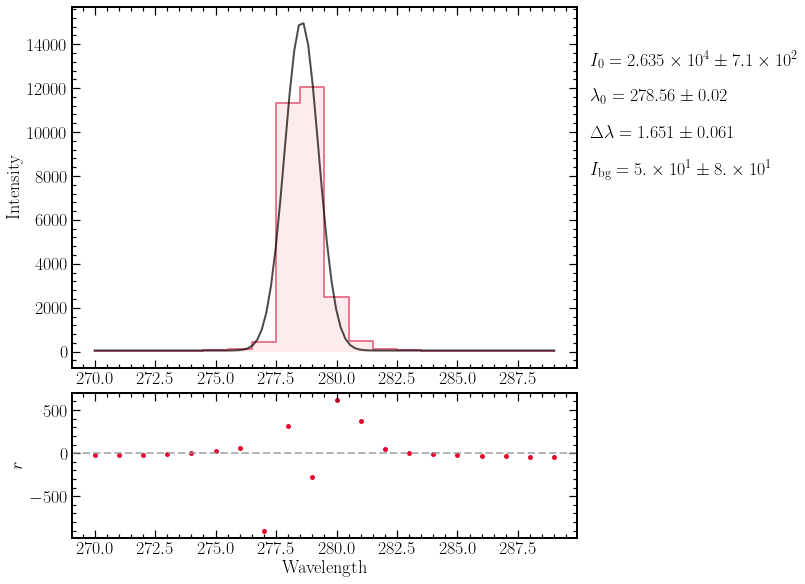

In [8]:
HeI_5016_slice_1 = slice(270,290)
HeI_5016_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_1], wvl=ccdx_array[HeI_5016_slice_1],line_number=1,line_wvl_init=[278],
                    int_max_init=[12000],fwhm_init=[1],same_width=False)
HeI_5016_model_1.run_lse(absolute_sigma=False)
HeI_5016_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

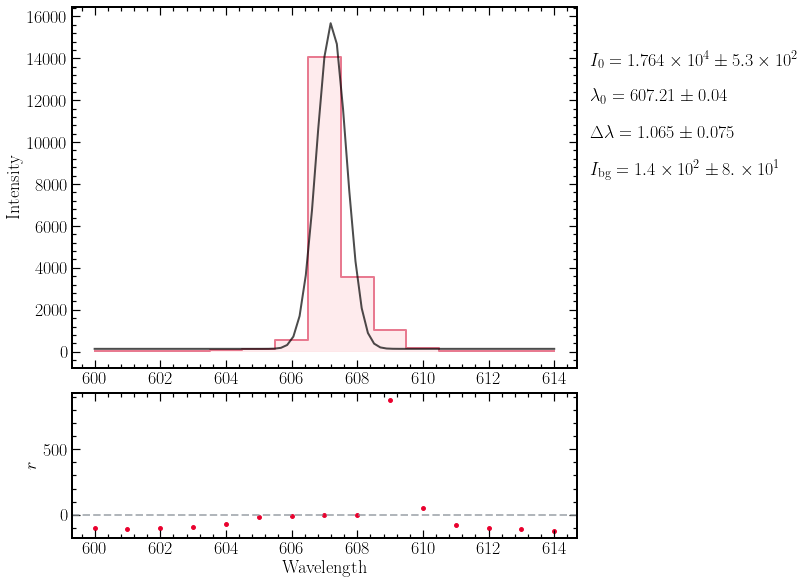

In [9]:
HeI_5016_slice_2 = slice(600,615)
HeI_5016_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_2], wvl=ccdx_array[HeI_5016_slice_2],line_number=1,line_wvl_init=[607],
                    int_max_init=[12000],fwhm_init=[2],same_width=False)
HeI_5016_model_2.run_lse(absolute_sigma=False)
HeI_5016_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

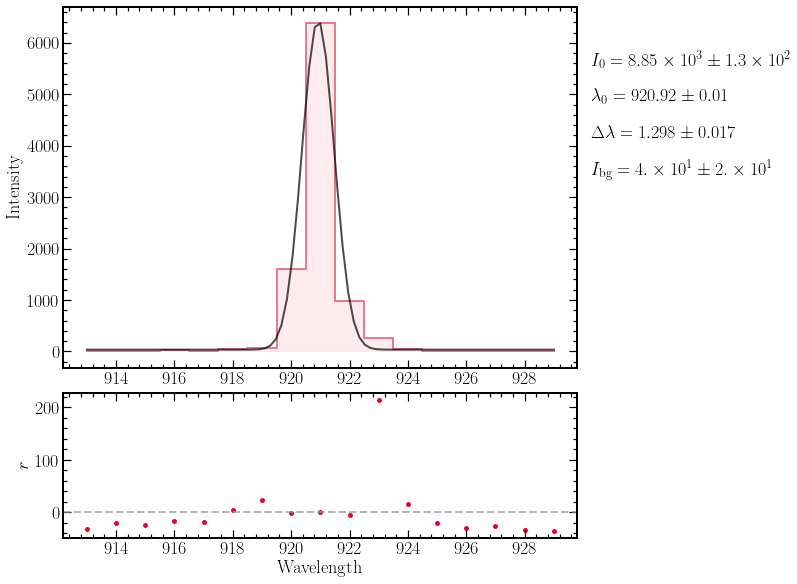

In [10]:
HeI_5016_slice_3 = slice(913,930)
HeI_5016_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_3], wvl=ccdx_array[HeI_5016_slice_3],line_number=1,line_wvl_init=[920],
                    int_max_init=[6000],fwhm_init=[2],same_width=False)
HeI_5016_model_3.run_lse(absolute_sigma=False)
HeI_5016_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

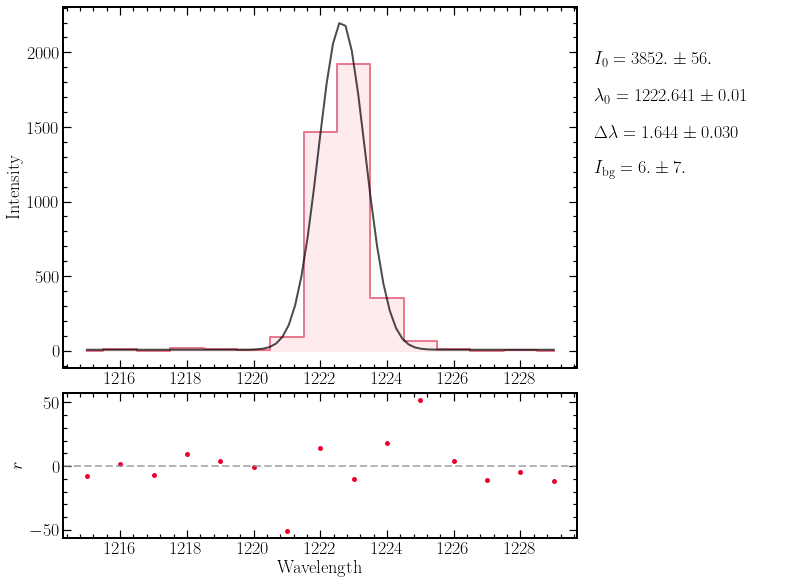

In [11]:
HeI_5016_slice_4 = slice(1215,1230)
HeI_5016_model_4 = SpectrumFitSingle(data=helium_spectrum_example[HeI_5016_slice_4], wvl=ccdx_array[HeI_5016_slice_4],line_number=1,line_wvl_init=[1222],
                    int_max_init=[2000],fwhm_init=[2],same_width=False)
HeI_5016_model_4.run_lse(absolute_sigma=False)
HeI_5016_model_4.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

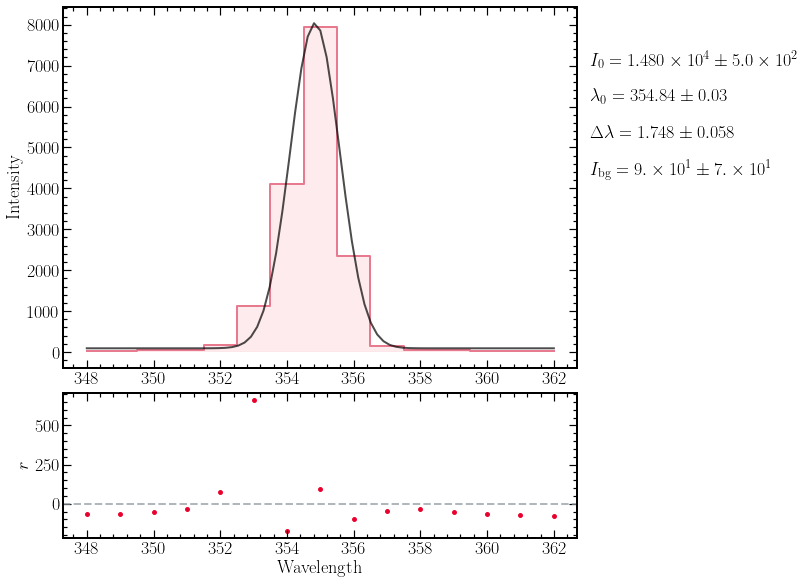

In [12]:
HeI_D3_slice_1 = slice(348,363)
HeI_D3_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_1], wvl=ccdx_array[HeI_D3_slice_1],line_number=1,line_wvl_init=[354],
                    int_max_init=[8000],fwhm_init=[1],same_width=False)
HeI_D3_model_1.run_lse(absolute_sigma=False)
HeI_D3_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

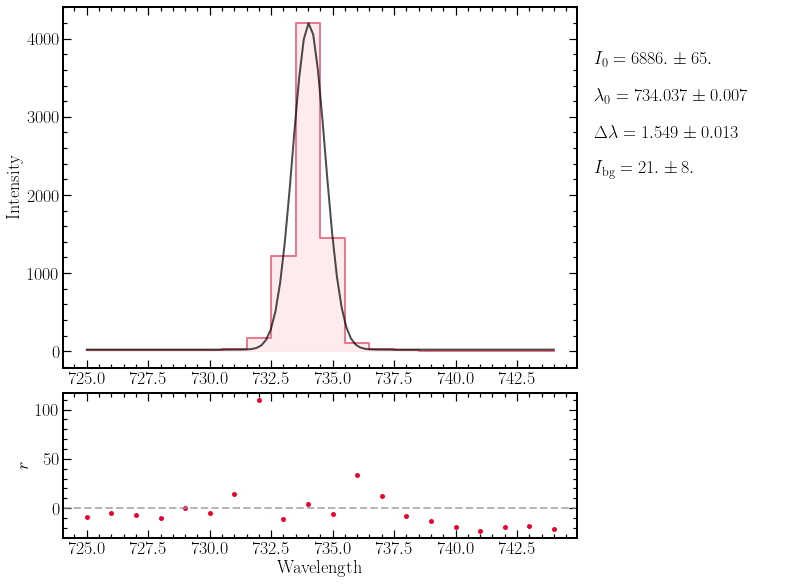

In [13]:
HeI_D3_slice_2 = slice(725,745)
HeI_D3_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_2], wvl=ccdx_array[HeI_D3_slice_2],line_number=1,line_wvl_init=[733],
                    int_max_init=[4000],fwhm_init=[1],same_width=False)
HeI_D3_model_2.run_lse(absolute_sigma=False)
HeI_D3_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

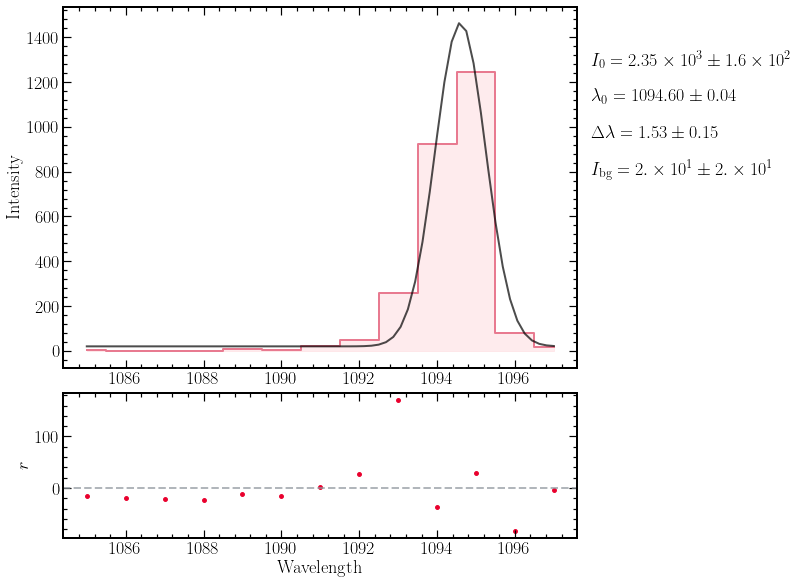

In [14]:
HeI_D3_slice_3 = slice(1085,1098)
HeI_D3_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_3], wvl=ccdx_array[HeI_D3_slice_3],line_number=1,line_wvl_init=[1094],
                    int_max_init=[14000],fwhm_init=[2],same_width=False)
HeI_D3_model_3.run_lse(absolute_sigma=False)
HeI_D3_model_3.plot(plot_fit=True)

In [15]:
HeI_5016_pos = np.array([HeI_5016_model.line_wvl_fit[0] for HeI_5016_model in 
                    (HeI_5016_model_1, HeI_5016_model_2, HeI_5016_model_3, HeI_5016_model_4)])
HeI_D3_pos = np.array([HeI_D3_model.line_wvl_fit[0] for HeI_D3_model in 
                    (HeI_D3_model_1, HeI_D3_model_2, HeI_D3_model_3)])

In [16]:
HeI_5016_pos[1:] - HeI_5016_pos[:-1]

array([328.6565064 , 313.71172098, 301.71717782])

In [17]:
HeI_D3_pos[1:] - HeI_D3_pos[:-1]

array([379.19743353, 360.56461627])

In [18]:
hydrogen_im_collection = ImageFileCollection(green_path,
                            glob_include="HydrogenGreen1s_2471*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [19]:
hydrogen_im_df

,file,simple,bitpix,naxis,naxis1,naxis2,bzero,bscale,datamin,datamax,...,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,xpossubf,ypossubf,cblack,cwhite,swcreate
0,HydrogenGreen1s_24710.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,760,7179,Artemis Capture
1,HydrogenGreen1s_24711.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,763,8029,Artemis Capture
2,HydrogenGreen1s_24712.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,759,8628,Artemis Capture
3,HydrogenGreen1s_24713.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,763,6774,Artemis Capture
4,HydrogenGreen1s_24714.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,763,6873,Artemis Capture
5,HydrogenGreen1s_24715.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,762,10427,Artemis Capture
6,HydrogenGreen1s_24716.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,763,10391,Artemis Capture
7,HydrogenGreen1s_24717.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,762,10278,Artemis Capture
8,HydrogenGreen1s_24718.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,762,10415,Artemis Capture
9,HydrogenGreen1s_24719.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,762,10398,Artemis Capture


In [20]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(green_path,row_["file"]),unit="adu").data - bias_dc_green_1s

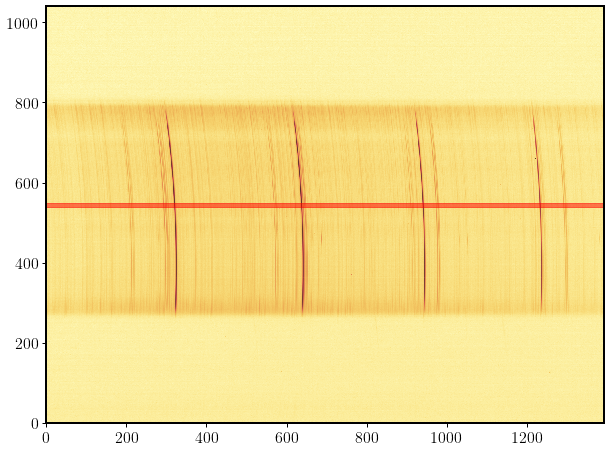

In [21]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
norm = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True,)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

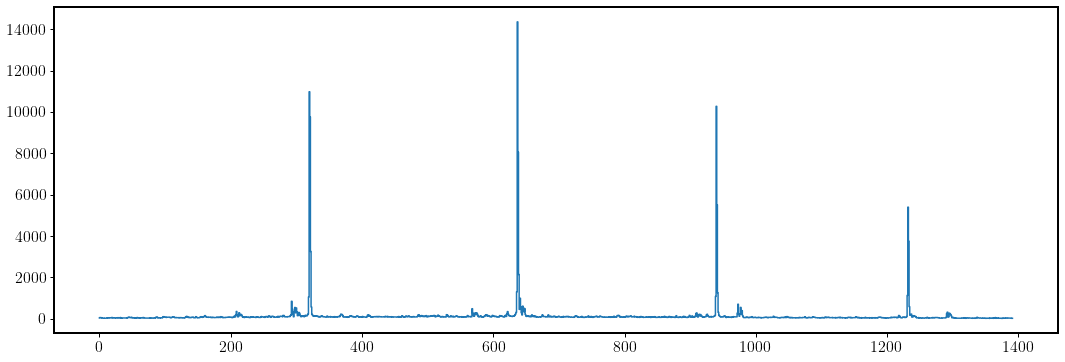

In [22]:
hydrogen_spectrum_example = np.mean(hydrogen_im_aver[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, hydrogen_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

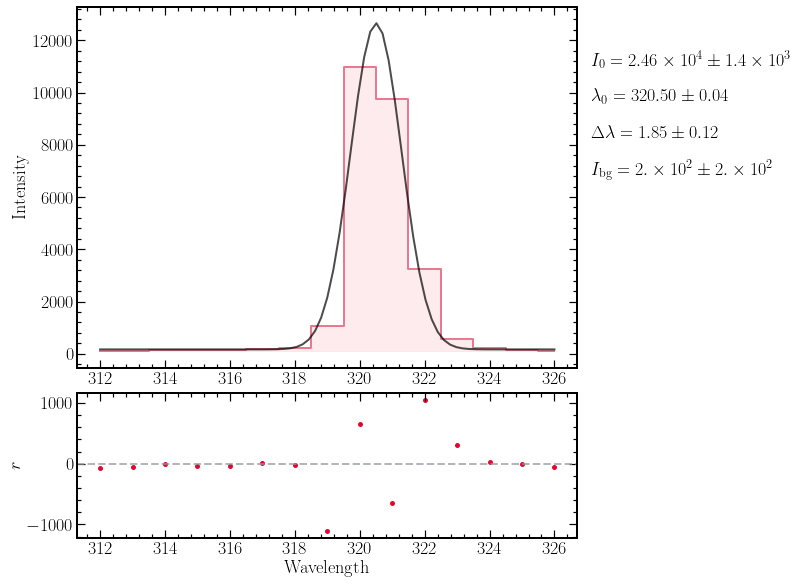

In [23]:
Hbeta_slice_1 = slice(312,327)
Hbeta_model_1 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_1], wvl=ccdx_array[Hbeta_slice_1],line_number=1,line_wvl_init=[320],
                    int_max_init=[10000],fwhm_init=[1],same_width=False)
Hbeta_model_1.run_lse(absolute_sigma=False)
Hbeta_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

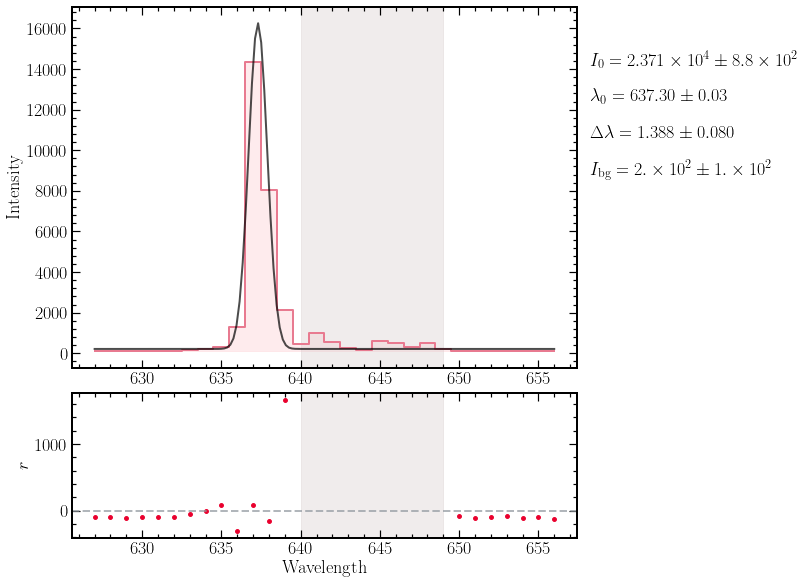

In [24]:
Hbeta_slice_2 = slice(627,657)
Hbeta_model_2 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_2], wvl=ccdx_array[Hbeta_slice_2],line_number=1,line_wvl_init=[637],
                    int_max_init=[12000],fwhm_init=[1],same_width=False,mask=[[640,649]])
Hbeta_model_2.run_lse(absolute_sigma=False)
Hbeta_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

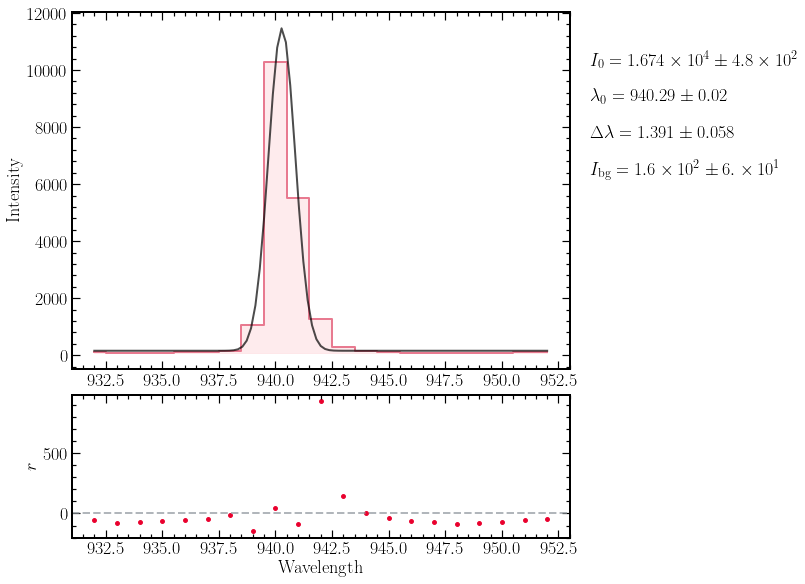

In [25]:
Hbeta_slice_3 = slice(932,953)
Hbeta_model_3 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_3], wvl=ccdx_array[Hbeta_slice_3],line_number=1,line_wvl_init=[939],
                    int_max_init=[8000],fwhm_init=[1],same_width=False)
Hbeta_model_3.run_lse(absolute_sigma=False)
Hbeta_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

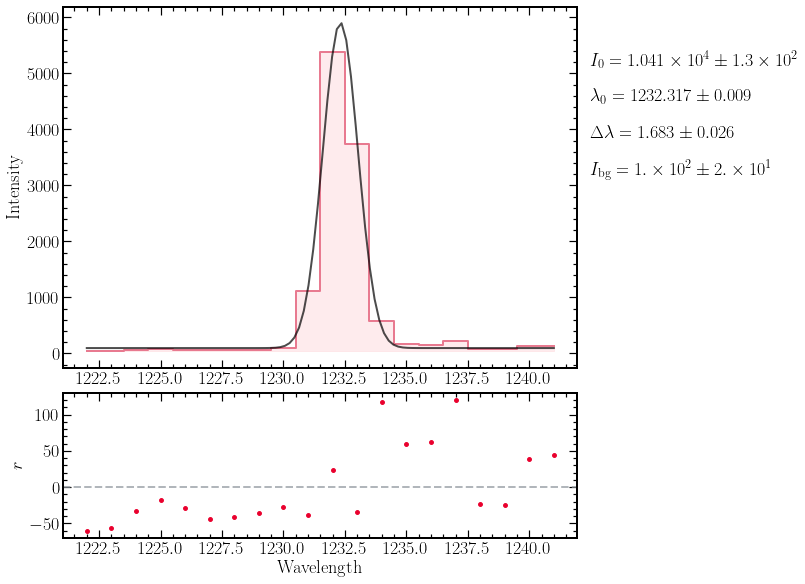

In [26]:
Hbeta_slice_4 = slice(1222,1242)
Hbeta_model_4 = SpectrumFitSingle(data=hydrogen_spectrum_example[Hbeta_slice_4], wvl=ccdx_array[Hbeta_slice_4],line_number=1,line_wvl_init=[1232],
                    int_max_init=[5000],fwhm_init=[1],same_width=False)
Hbeta_model_4.run_lse(absolute_sigma=False)
Hbeta_model_4.plot(plot_fit=True)

In [27]:
Hbeta_pos = np.array([Hbeta_model.line_wvl_fit[0] for Hbeta_model in 
                    (Hbeta_model_1, Hbeta_model_2, Hbeta_model_3, Hbeta_model_4)])

In [28]:
Hbeta_pos[1:] - Hbeta_pos[:-1]

array([316.7996502 , 302.98117575, 292.03138507])

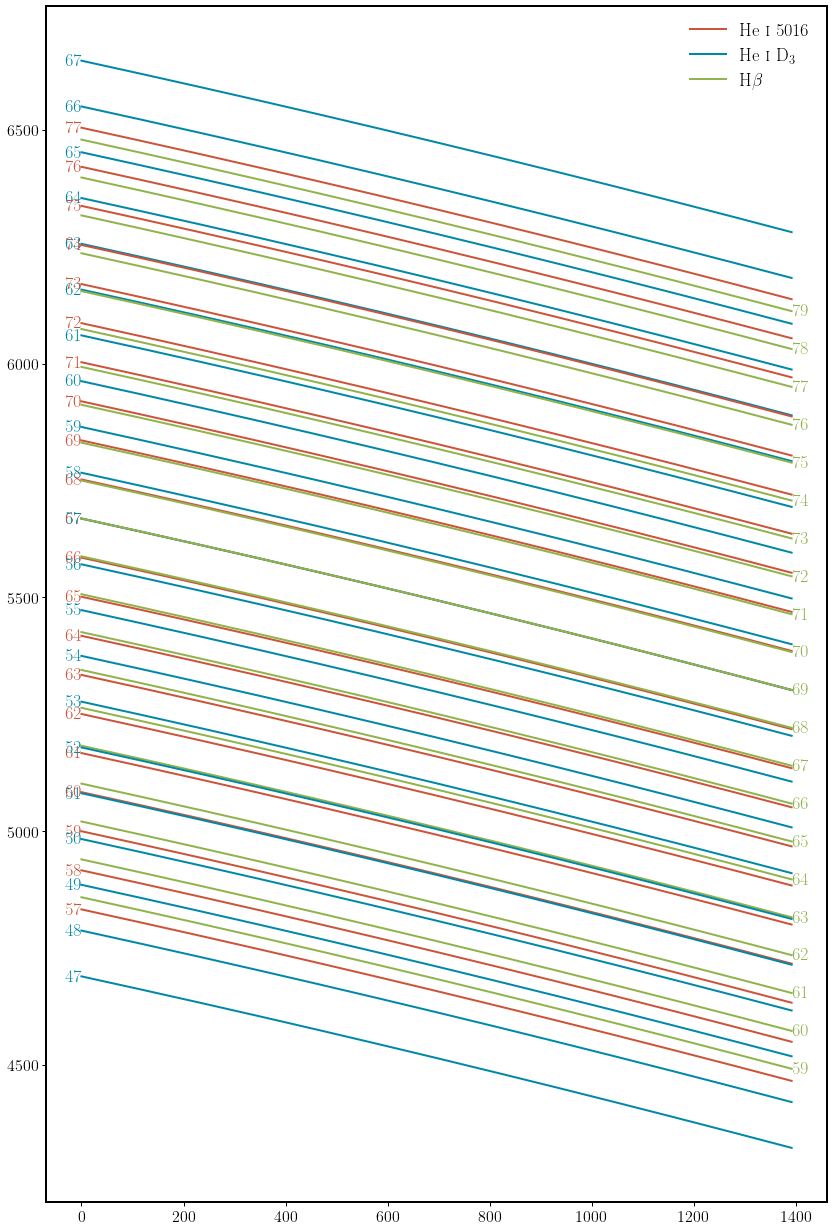

In [29]:
scale_factor = 60
HeI_5016_start_order_guess = 67
HeI_D3_start_order_guess = 57
Hbeta_start_order_guess = 69

order_variation = 10
fig, ax = plt.subplots(figsize=(14,order_variation*2 + 2))

for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_5016_wvl_guess_new = 5015.6783  * np.arange(HeI_5016_start_order_guess + order_new,
                             HeI_5016_start_order_guess + order_new - 4,-1)/scale_factor
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                                HeI_D3_start_order_guess + order_new - 3,-1)/scale_factor
    Hbeta_wvl_guess_new = 4861.35 * np.arange(Hbeta_start_order_guess + order_new,
                             Hbeta_start_order_guess + order_new - 4,-1)/scale_factor
    
    poly_fit_5016_param = np.polyfit(HeI_5016_pos, HeI_5016_wvl_guess_new, 2)
    poly_fit_5016_func = np.poly1d(poly_fit_5016_param)
    poly_fit_5016_curve = poly_fit_5016_func(ccdx_array)

    poly_fit_6678_param = np.polyfit(HeI_D3_pos, HeI_D3_wvl_guess_new, 2)
    poly_fit_6678_func = np.poly1d(poly_fit_6678_param)
    poly_fit_6678_curve = poly_fit_6678_func(ccdx_array)

    poly_fit_hbeta_param = np.polyfit(Hbeta_pos, Hbeta_wvl_guess_new, 2)
    poly_fit_hbeta_func = np.poly1d(poly_fit_hbeta_param)
    poly_fit_hbeta_curve = poly_fit_hbeta_func(ccdx_array)

    ln1, = ax.plot(ccdx_array, poly_fit_5016_curve,color="#CC543A",lw=2,
            label=r"He \textsc{i} 5016")
    ax.text(0, poly_fit_5016_curve[0],"{:2d}".format(HeI_5016_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#CC543A")

    ln2, = ax.plot(ccdx_array, poly_fit_6678_curve,color="#0089A7",lw=2,
            label=r"He \textsc{i} $\rm D_3$")
    ax.text(0, poly_fit_6678_curve[0],"{:2d}".format(HeI_D3_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#0089A7")

    ln3, = ax.plot(ccdx_array, poly_fit_hbeta_curve,color="#90B44B",lw=2,
            label=r"H$\beta$")
    ax.text(1392, poly_fit_hbeta_curve[-1],"{:2d}".format(Hbeta_start_order_guess + order_new),
            va="center",ha="left",fontsize=18,color="#90B44B")

    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

ax.tick_params(labelsize=16)



Text(0, 0.5, 'Wavelength $\\lambda$\\,[\\mbox{\\AA}]')

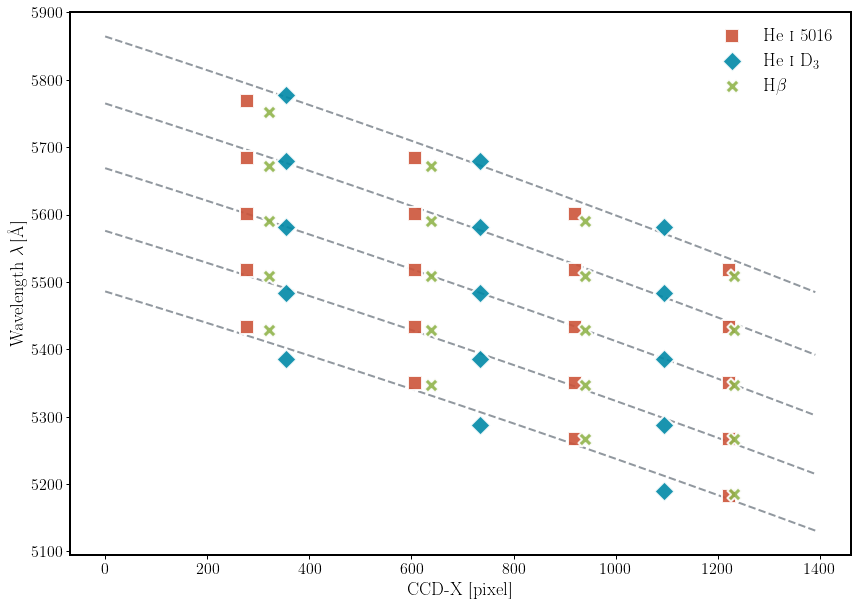

In [30]:
base_order = 60
HeI_5016_start_order_guess = 67
HeI_D3_start_order_guess = 57
Hbeta_start_order_guess = 69

HeI_5016_wvl_guess = 5015.6783 * np.arange(HeI_5016_start_order_guess, HeI_5016_start_order_guess - 4,-1)/base_order
HeI_D3_wvl_guess = 5875.621 * np.arange(HeI_D3_start_order_guess, HeI_D3_start_order_guess - 3,-1)/base_order
Hbeta_wvl_guess = 4861.35 * np.arange(Hbeta_start_order_guess, Hbeta_start_order_guess - 4,-1)/base_order

line_pos_all = np.concatenate([HeI_5016_pos, HeI_D3_pos,Hbeta_pos])
line_wvl_guess_all = np.concatenate([HeI_5016_wvl_guess, HeI_D3_wvl_guess,Hbeta_wvl_guess])

poly_fit_param = np.polyfit(line_pos_all, line_wvl_guess_all, 2)
poly_fit_func = np.poly1d(poly_fit_param)
poly_fit_curve = poly_fit_func(ccdx_array)

order_variation = 2
fig, ax = plt.subplots(figsize=(14,order_variation*4 + 2))


for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_5016_wvl_guess_new = 5015.6783 * np.arange(HeI_5016_start_order_guess + order_new,
                             HeI_5016_start_order_guess + order_new - 4,-1)/base_order
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                                HeI_D3_start_order_guess + order_new - 3,-1)/base_order
    Hbeta_wvl_guess_new = 4861.35 * np.arange(Hbeta_start_order_guess + order_new,
                                Hbeta_start_order_guess + order_new - 4,-1)/base_order

    ln1 = ax.scatter(HeI_5016_pos, HeI_5016_wvl_guess_new,marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} 5016")
    ln2 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess_new,marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} $\rm D_3$")
    ln3 = ax.scatter(Hbeta_pos, Hbeta_wvl_guess_new,marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"H$\beta$")
    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

    ax.plot(ccdx_array, poly_fit_curve*base_order/(base_order + order_new),lw=2,ls="--",color="#91989F",zorder=0)


# for plot_order in np.arange(base_order - 5, base_order + 5):
#     ax.scatter()

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [pixel]",fontsize=18)
ax.set_ylabel(r"Wavelength $\lambda$\,[\mbox{\AA}]",fontsize=18)

In [31]:
totality_image_fname = "TotalitySequenceGreen_22717(2).fit"
totality_frame = CCDData.read(os.path.join(green_path, totality_image_fname),unit="adu")

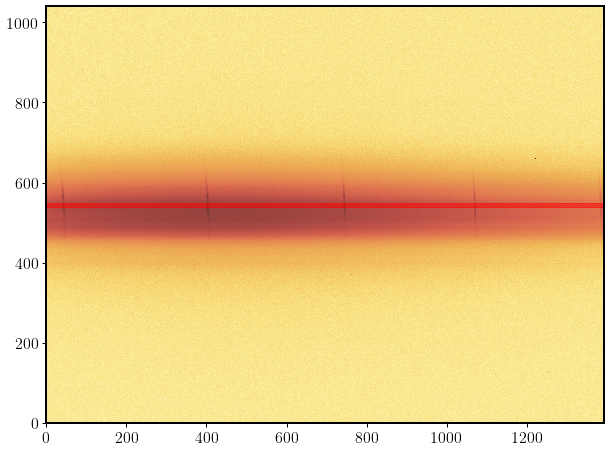

In [32]:
totality_image = (totality_frame.data - bias_dc_green_1s)//totality_frame.header["EXPTIME"]
norm = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
ax.tick_params(labelsize=16)

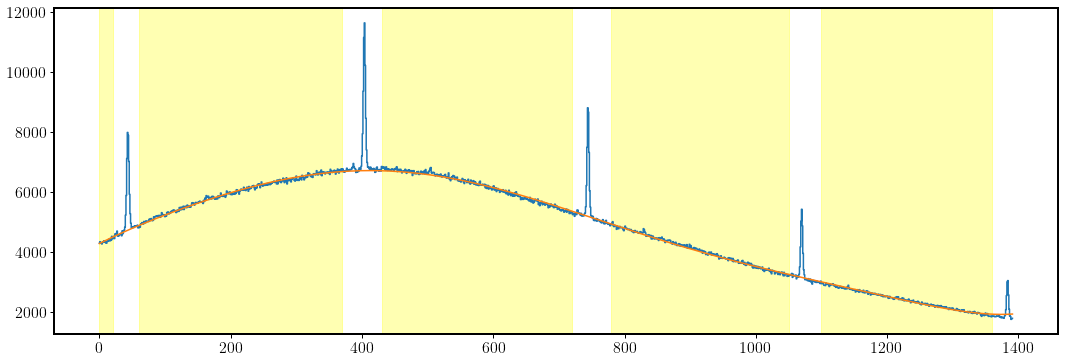

In [44]:
totality_spectrum_example = np.mean(totality_image[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, totality_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

fit_intervals = [slice(0,20),slice(60,370),slice(430,720),slice(780,1050),slice(1100,1360)]
for fit_interval in fit_intervals:
    ax.axvspan(fit_interval.start,fit_interval.stop,color="yellow",alpha=0.3)

background_poly_order = 7
wvl_array_to_fit = np.concatenate([ccdx_array[fit_interval] for fit_interval in fit_intervals])
spectra_to_fit = np.concatenate([totality_spectrum_example[fit_interval] for fit_interval in fit_intervals])
background_poly_params = np.polyfit(wvl_array_to_fit,spectra_to_fit,background_poly_order)
background_poly_func = np.poly1d(background_poly_params)
background_poly_curve = background_poly_func(ccdx_array)

ax.plot(ccdx_array, background_poly_curve, label="{:.0f}th".format(background_poly_order))

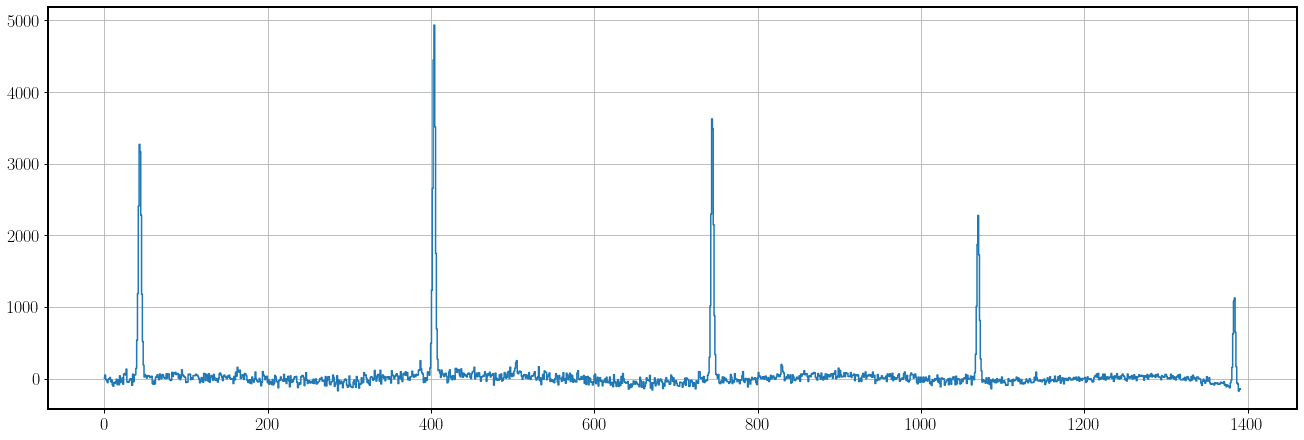

In [45]:
totality_spectrum_no_background = totality_spectrum_example - background_poly_curve
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
ax.step(ccdx_array, totality_spectrum_no_background, where="mid")
ax.tick_params(labelsize=18)
ax.grid("on")

<AxesSubplot:ylabel='Intensity'>

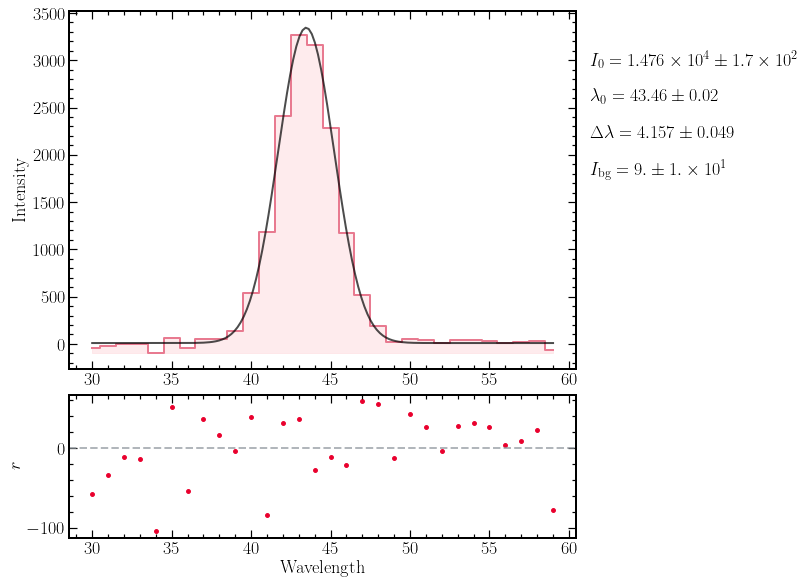

In [48]:
FeXIV_5303_slice_1 = slice(30,60)
FeXIV_5303_model_1 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_1], wvl=ccdx_array[FeXIV_5303_slice_1],line_number=1,line_wvl_init=[44],
                    int_max_init=[300],fwhm_init=[1],same_width=False)
FeXIV_5303_model_1.run_lse(absolute_sigma=False)
FeXIV_5303_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

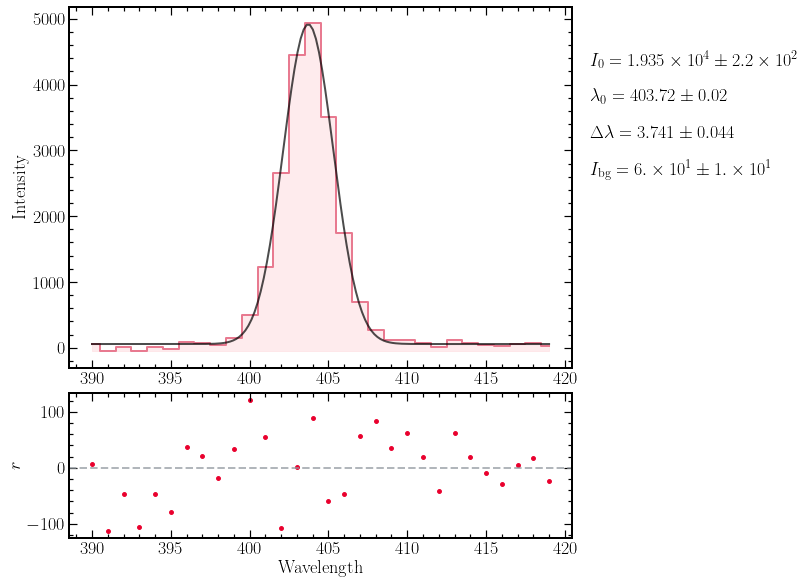

In [51]:
FeXIV_5303_slice_2 = slice(390,420)
FeXIV_5303_model_2 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_2], wvl=ccdx_array[FeXIV_5303_slice_2],line_number=1,line_wvl_init=[402],
                    int_max_init=[5000],fwhm_init=[1],same_width=False)
FeXIV_5303_model_2.run_lse(absolute_sigma=False)
FeXIV_5303_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

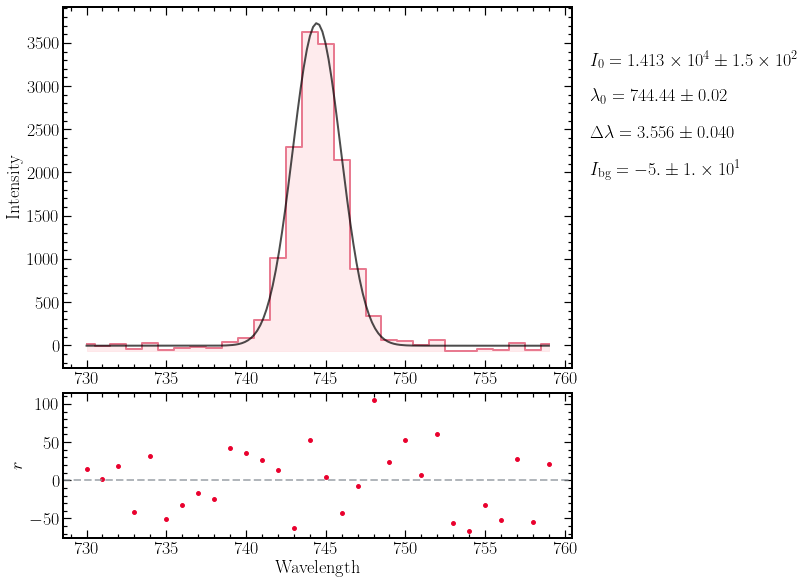

In [54]:
FeXIV_5303_slice_3 = slice(730,760)
FeXIV_5303_model_3 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_3], wvl=ccdx_array[FeXIV_5303_slice_3],line_number=1,line_wvl_init=[744],
                    int_max_init=[3500],fwhm_init=[1],same_width=False)
FeXIV_5303_model_3.run_lse(absolute_sigma=False)
FeXIV_5303_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

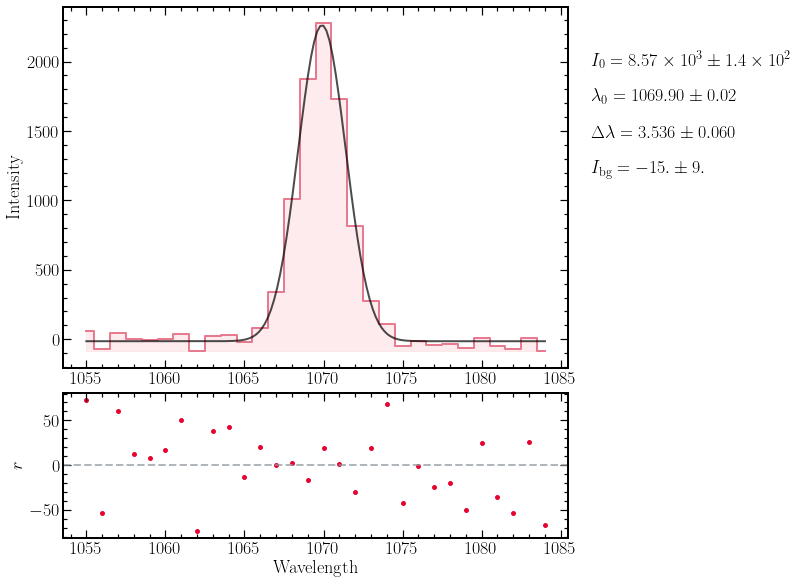

In [58]:
FeXIV_5303_slice_4 = slice(1055,1085)
FeXIV_5303_model_4 = SpectrumFitSingle(data=totality_spectrum_no_background[FeXIV_5303_slice_4], wvl=ccdx_array[FeXIV_5303_slice_4],line_number=1,line_wvl_init=[1070],
                    int_max_init=[2000],fwhm_init=[1],same_width=False)
FeXIV_5303_model_4.run_lse(absolute_sigma=False)
FeXIV_5303_model_4.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

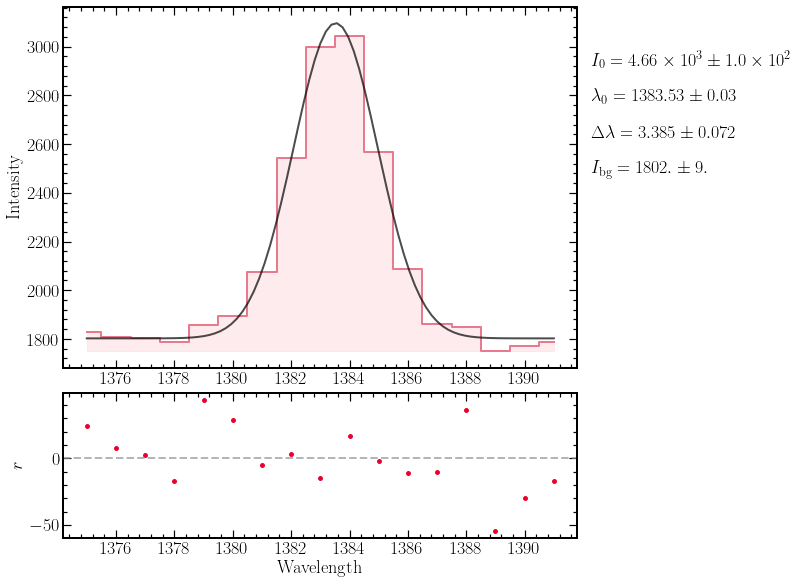

In [63]:
FeXIV_5303_slice_5 = slice(1375,1392)
FeXIV_5303_model_5 = SpectrumFitSingle(data=totality_spectrum_example[FeXIV_5303_slice_5], wvl=ccdx_array[FeXIV_5303_slice_5],line_number=1,line_wvl_init=[1383],
                    int_max_init=[3000],fwhm_init=[1],same_width=False)
FeXIV_5303_model_5.run_lse(absolute_sigma=False)
FeXIV_5303_model_5.plot(plot_fit=True)

In [66]:
for FeXIV_5303_model_ in (FeXIV_5303_model_1,FeXIV_5303_model_2,FeXIV_5303_model_3,FeXIV_5303_model_4):
    print(poly_fit_func(FeXIV_5303_model_.line_wvl_fit[0])*base_order/5302.86)

64.02278971687626
63.01721211496309
62.0175079813103
61.01843231647005


In [68]:
FeXIV_5303_pos = np.array([FeXIV_5303_model.line_wvl_fit[0] for FeXIV_5303_model in 
                    (FeXIV_5303_model_1, FeXIV_5303_model_2, FeXIV_5303_model_3,FeXIV_5303_model_4,FeXIV_5303_model_5)])


Text(0.5, 0, '\\textbf{CCD-X [Pixel]}')

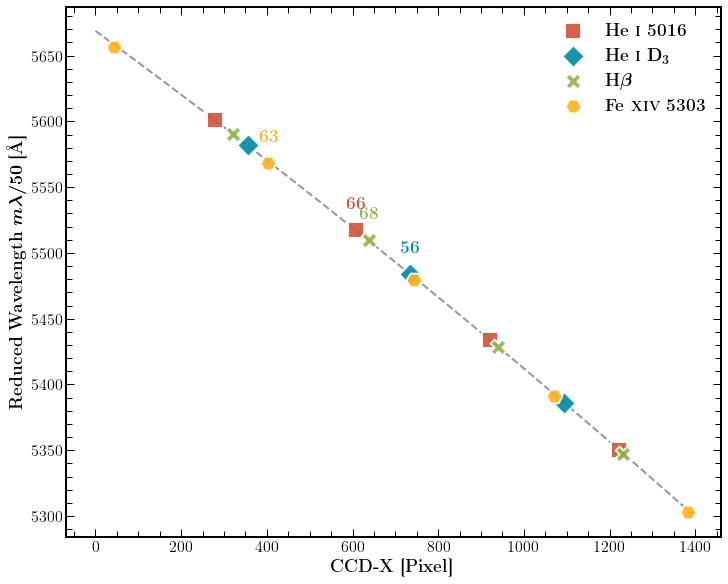

In [72]:
FeXIV_5303_start_order_guess = 64
FeXIV_5303_wvl_guess = 5302.86 * np.arange(FeXIV_5303_start_order_guess, FeXIV_5303_start_order_guess - 5, -1)/base_order

fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)

ln1 = ax.scatter(HeI_5016_pos, HeI_5016_wvl_guess,marker= "s",s=250,facecolor="#CC543A",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} 5016}")
ln2 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess,marker= "D",s=250,facecolor="#0089A7",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} $\boldsymbol{\rm D_3}$}")
ln3 = ax.scatter(Hbeta_pos, Hbeta_wvl_guess,marker= "X",s=250,facecolor="#90B44B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{H}$\boldsymbol{\beta}$")
ln4 = ax.scatter(FeXIV_5303_pos, FeXIV_5303_wvl_guess,marker= "H",s=250,facecolor="#FFB11B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Fe \textsc{xiv} 5303}")

leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)

ax.plot(ccdx_array, poly_fit_curve,lw=2,ls="--",color="#91989F",zorder=0)
ax.text(Hbeta_pos[1], Hbeta_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(Hbeta_start_order_guess-1),color="#90B44B",
        fontsize=18,ha="center",va="center")
ax.text(HeI_5016_pos[1], HeI_5016_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(HeI_5016_start_order_guess-1),color="#CC543A",
        fontsize=18,ha="center",va="center")
ax.text(HeI_D3_pos[1], HeI_D3_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(HeI_D3_start_order_guess-1),color="#0089A7",
        fontsize=18,ha="center",va="center")
ax.text(FeXIV_5303_pos[1], FeXIV_5303_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(FeXIV_5303_start_order_guess-1),color="#FFB11B",
        fontsize=18,ha="center",va="center")

ax.tick_params(labelsize=16,direction="in",which="both",right=True,top=True)
ax.tick_params(length=8,which="major")
ax.tick_params(length=6,which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel(r"\textbf{Reduced Wavelength} $\boldsymbol{m\lambda/50}$ \textbf{[\mbox{\AA}]}",fontsize=18)
ax.set_xlabel(r"\textbf{CCD-X [Pixel]}",fontsize=18)
#plt.savefig(fname="../../figs/calib/wvl_calib_red_eclipse_2017.pdf",dpi=300)